# DeepLoc Projet - by Mélina Farshchi

# Introduction

### Goal
* Predict 10 locations + membrane vs solubre from the protein sequence.
* Progressive approaches : CNN ➡ BiLSTM ➡ CNN + BiLSTM + Attention

### Protocol
CV by partition (0-4) + independent HPA test => not done.

### Metrics
mean, sd, accuracy, balanced accuracy,F1-macro, MCC, PR-AUC, confusion matrix.

### DeepLoc particularity
Max length 1200 aa & remove the middle to keep N/C terminus.

## Setup & libraries

In [3]:
# !pip -q install numpy pandas scikit-learn matplotlib tensorflow==2.15.0

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, random
from typing import Dict, Tuple
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef,
                             average_precision_score, precision_recall_curve, confusion_matrix)
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


np.random.seed(12345); random.seed(12345); tf.random.set_seed(12345)
print("TF", tf.__version__)


TF 2.19.0


# Data loading and encoding

In [4]:
# --- Mount & workspace ---
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive
%mkdir -p workshop-tmp/dataset
%cd /content/drive/MyDrive/workshop-tmp
%pwd

# --- Downloader (progress + resumable-ish) ---
import os, requests, math
from tqdm.auto import tqdm

DATA_DIR = "dataset"
os.makedirs(DATA_DIR, exist_ok=True)

DL21_URLS = {
    # Files names
    "trainval_subcellular":  "https://services.healthtech.dtu.dk/services/DeepLoc-2.1/data/Swissprot_Train_Validation_dataset.csv",
    "trainval_membrane":     "https://services.healthtech.dtu.dk/services/DeepLoc-2.1/data/Swissprot_Membrane_Train_Validation_dataset.csv",
    "sorting_signals":       "https://services.healthtech.dtu.dk/services/DeepLoc-2.1/data/SortingSignalsSwissprot.csv",
}

def _infer_filename(url: str, fallback: str) -> str:
    tail = url.split("?")[0].split("/")[-1]
    return tail if tail and "." in tail else fallback

def download_file(url: str, out_path: str, chunk=1<<14):
    r = requests.get(url, stream=True)
    r.raise_for_status()
    total = int(r.headers.get("content-length", 0))
    with open(out_path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=os.path.basename(out_path)) as pbar:
        for chunk_bytes in r.iter_content(chunk_size=chunk):
            if chunk_bytes:
                f.write(chunk_bytes)
                pbar.update(len(chunk_bytes))

def download_deeploc21(url_map: dict, data_dir: str = DATA_DIR):
    saved = {}
    for key, url in url_map.items():
        if not url:
            print(f"[WARN] Missing URL for: {key}. Please paste it from the DeepLoc-2.1 page.")
            continue
        fname = _infer_filename(url, f"{key}.csv")
        out_path = os.path.join(data_dir, fname)
        if os.path.exists(out_path):
            print(f"[SKIP] {fname} exists.")
        else:
            download_file(url, out_path)
        saved[key] = out_path
    return saved

DL21_FILES = download_deeploc21(DL21_URLS, DATA_DIR)
DL21_FILES


Mounted at /content/drive
/content/drive/MyDrive
/content/drive/MyDrive/workshop-tmp
[SKIP] Swissprot_Train_Validation_dataset.csv exists.
[SKIP] Swissprot_Membrane_Train_Validation_dataset.csv exists.
[SKIP] SortingSignalsSwissprot.csv exists.


{'trainval_subcellular': 'dataset/Swissprot_Train_Validation_dataset.csv',
 'trainval_membrane': 'dataset/Swissprot_Membrane_Train_Validation_dataset.csv',
 'sorting_signals': 'dataset/SortingSignalsSwissprot.csv'}

## Checking the dataset & columns

In [5]:
# Load datasets from downloaded files
df_loc = pd.read_csv(DL21_FILES["trainval_subcellular"])
df_mem = pd.read_csv(DL21_FILES["trainval_membrane"])
df_sig = pd.read_csv(DL21_FILES["sorting_signals"])

print("DataFrames loaded:")
print("df_loc:", df_loc.shape)
print("df_mem:", df_mem.shape)
print("df_sig:", df_sig.shape)

DataFrames loaded:
df_loc: (28303, 16)
df_mem: (28026, 9)
df_sig: (1874, 5)


## Column normalisation & sequence length

In [6]:
# Column lists
LOC_COLS = [
    "Cytoplasm","Nucleus","Extracellular","Cell membrane","Mitochondrion",
    "Plastid","Endoplasmic reticulum","Lysosome/Vacuole","Golgi apparatus","Peroxisome"
]
MEMTYPE_COLS = ["Peripheral","Transmembrane","LipidAnchor","Soluble"]

def coerce_label_cols(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(float)
    return df

# Coerce labels to numeric
df_loc = coerce_label_cols(df_loc, LOC_COLS + (["Membrane"] if "Membrane" in df_loc.columns else []))
if df_mem is not None:
    df_mem = coerce_label_cols(df_mem, MEMTYPE_COLS)

# Sequence lengths
df_loc["seq_len"] = df_loc["Sequence"].astype(str).str.len()
if df_mem is not None: df_mem["seq_len"] = df_mem["Sequence"].astype(str).str.len()

# Quick shapes
print("Subcellular:", df_loc.shape)
print("Membrane   :", None if df_mem is None else df_mem.shape)
print("Signals    :", None if df_sig is None else df_sig.shape)


Subcellular: (28303, 17)
Membrane   : (28026, 10)
Signals    : (1874, 5)


## Length distribution

In [7]:
def summarize_lengths(name, s):
    print(f"{name}: n={len(s)}, min={int(s.min())}, median={float(s.median()):.1f}, "
          f"mean={float(s.mean()):.1f}, p95={float(s.quantile(0.95)):.1f}, max={int(s.max())}")

summarize_lengths("Train/Val subcellular", df_loc["seq_len"])
if df_mem is not None: summarize_lengths("Train/Val membrane", df_mem["seq_len"])

# Removed plotting code

Train/Val subcellular: n=28303, min=40, median=433.0, mean=556.9, p95=1382.0, max=34350
Train/Val membrane: n=28026, min=40, median=413.0, mean=526.0, p95=1341.0, max=5654


## Partition & Kingdom distributions (sanity for CV)

In [8]:
# Partition counts (homology-aware folds)
if "Partition" in df_loc.columns:
    part_counts = df_loc["Partition"].value_counts().sort_index()
    print("Partition counts (subcellular):\n", part_counts)

# Kingdom distribution
if "Kingdom" in df_loc.columns:
    k_counts = df_loc["Kingdom"].value_counts()
    print("\nKingdom counts:\n", k_counts)


Partition counts (subcellular):
 Partition
0    5963
1    5451
2    5731
3    5696
4    5462
Name: count, dtype: int64

Kingdom counts:
 Kingdom
Metazoa          16741
Fungi             5841
Viridiplantae     5116
Other              605
Name: count, dtype: int64


Metazoa (animals) → 16,741 (~59%)

Fungi → 5,841 (~21%)

Viridiplantae (plants) → 5,116 (~18%)

Other (protists, etc.) → 605 (~2%)

The dataset is dominated by animals, but still has a good representation of fungi and plants.
This is important context: when we later evaluate the model, we'l know that performance is mostly driven by eukaryotic proteins.

## Multi-label intensity (how many location labels per protein)

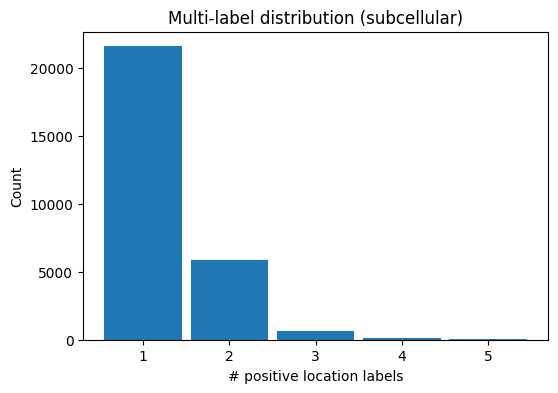

Mean #labels: 1.2710313394339823


In [ ]:
loc_pos = (df_loc[LOC_COLS] > 0.5).sum(axis=1)
plt.figure(figsize=(6,4))
plt.hist(loc_pos, bins=np.arange(loc_pos.min(), loc_pos.max()+2)-0.5, rwidth=0.9)
plt.xlabel("# positive location labels"); plt.ylabel("Count")
plt.title("Multi-label distribution (subcellular)")
plt.show()
print("Mean #labels:", loc_pos.mean())


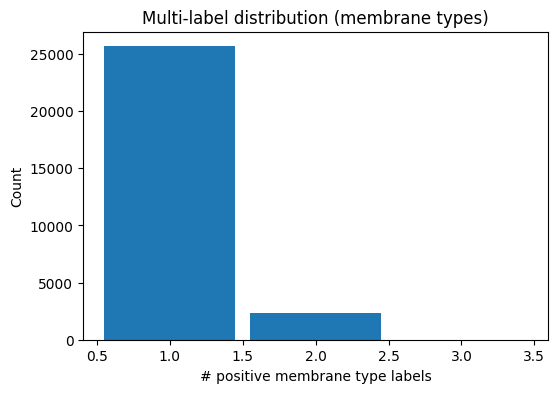

Mean #labels: 1.0843145650467423


In [9]:
# Multi-label intensity for membrane types
if df_mem is not None and all(c in df_mem.columns for c in MEMTYPE_COLS):
    mem_pos = (df_mem[MEMTYPE_COLS] > 0.5).sum(axis=1)
    plt.figure(figsize=(6,4))
    plt.hist(mem_pos, bins=np.arange(mem_pos.min(), mem_pos.max()+2)-0.5, rwidth=0.9)
    plt.xlabel("# positive membrane type labels"); plt.ylabel("Count")
    plt.title("Multi-label distribution (membrane types)")
    plt.show()
    print("Mean #labels:", mem_pos.mean())
else:
    print("df_mem is not available or missing membrane type columns.")

We want to keep the multi-labels proteins because biologically it makes sense. Lots of proteins do have dual or even dynamic localizations (e.g. transcription factors that shuttle between nucleus ↔ cytoplasm, or metabolic enzymes found in cytosol + mitochondria). Removing them makes the dataset “cleaner”, but less realistic.

## Class balance (subcellular + membrane types)

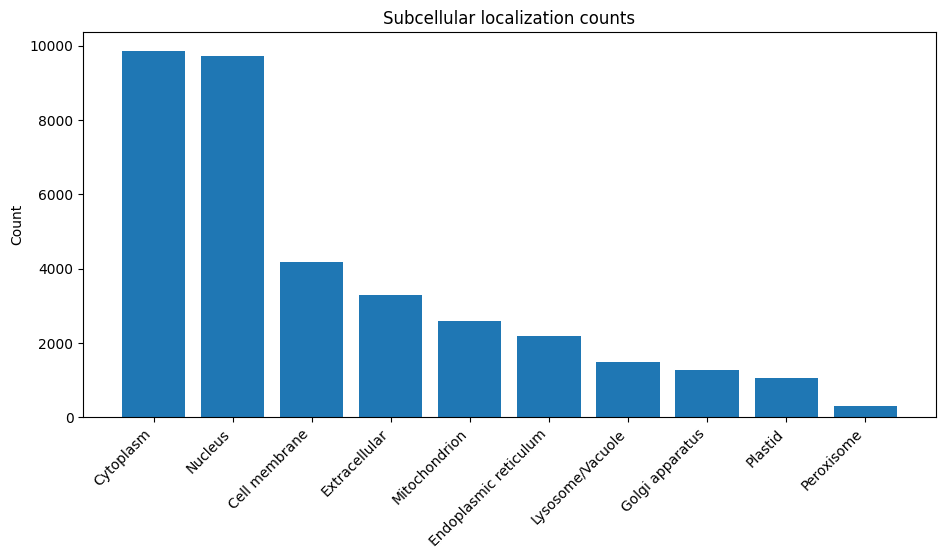

,Cytoplasm,Nucleus,Cell membrane,Extracellular,Mitochondrion,Endoplasmic reticulum,Lysosome/Vacuole,Golgi apparatus,Plastid,Peroxisome
count,9870,9720,4187,3301,2590,2180,1496,1279,1047,304


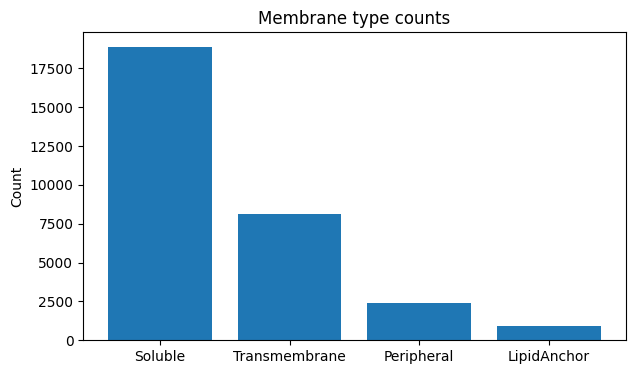

,Soluble,Transmembrane,Peripheral,LipidAnchor
count,18872,8151,2419,947


In [ ]:
# Subcellular labels
loc_counts = df_loc[LOC_COLS].sum().sort_values(ascending=False)
plt.figure(figsize=(11,5))
plt.bar(loc_counts.index, loc_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count"); plt.title("Subcellular localization counts")
plt.show()
display(loc_counts.astype(int).to_frame("count").T)

# Membrane-type labels
if df_mem is not None and all(c in df_mem.columns for c in MEMTYPE_COLS):
    mem_counts = df_mem[MEMTYPE_COLS].sum().sort_values(ascending=False)
    plt.figure(figsize=(7,4))
    plt.bar(mem_counts.index, mem_counts.values)
    plt.ylabel("Count"); plt.title("Membrane type counts")
    plt.show()
    display(mem_counts.astype(int).to_frame("count").T)


Data pre-processing on length

In [ ]:
# === Preprocessing config ===
MAX_LEN = 1200
AA = list("ACDEFGHIKLMNPQRSTVWY")  # 20 standard AAs
AA_to_i = {a:i for i,a in enumerate(AA)}

# 1) Truncate by removing the middle (keeps N- and C-termini)
def truncate_middle(seq: str, max_len: int = MAX_LEN) -> str:
    s = str(seq)
    if len(s) <= max_len:
        return s
    keep_head = max_len // 2
    keep_tail = max_len - keep_head
    return s[:keep_head] + s[-keep_tail:]

# 2) Center-pad (pad token = all zeros in one-hot)
import numpy as np
def center_pad_onehot(X: np.ndarray, L: int) -> np.ndarray:
    T, F = X.shape
    if T == L:
        return X
    if T > L:  # safety: also trim here if needed
        head = L // 2
        tail = L - head
        return np.vstack([X[:head], X[-tail:]])
    pad = L - T
    left = pad // 2
    right = pad - left
    return np.vstack([np.zeros((left, F), dtype=np.float32), X, np.zeros((right, F), dtype=np.float32)])

# 3) One-hot encoding (unknowns -> zero vector)
def one_hot(seq: str) -> np.ndarray:
    s = str(seq)
    X = np.zeros((len(s), len(AA)), dtype=np.float32)
    for t, ch in enumerate(s):
        if ch in AA_to_i:
            X[t, AA_to_i[ch]] = 1.0
        # else: unknowns (e.g., 'X', 'U', 'B', 'Z') stay as zero rows
    return X

# 4) End-to-end: sequence -> [MAX_LEN, 20] tensor
def encode_sequence_1200_onehot(seq: str) -> np.ndarray:
    seq = truncate_middle(seq, MAX_LEN)
    X = one_hot(seq)
    X = center_pad_onehot(X, MAX_LEN)
    return X

# --- Apply to our dataframes (subcellular & membrane share the same 'Sequence' column) ---
# Note: HPA uses 'fasta' column for the sequence.

def build_tensor_dataset(df: pd.DataFrame, seq_col: str):
    X = np.stack([encode_sequence_1200_onehot(s) for s in df[seq_col].astype(str)], axis=0)
    return X  # shape [N, 1200, 20]

# Quick diagnostics: how many will be truncated with MAX_LEN=1200?
def truncation_report(df_seq_lengths: pd.Series, max_len: int = MAX_LEN, name="set"):
    n = len(df_seq_lengths)
    n_trunc = int((df_seq_lengths > max_len).sum())
    pct = 100.0 * n_trunc / n if n>0 else 0.0
    print(f"{name}: {n_trunc}/{n} sequences ({pct:.2f}%) exceed {max_len} aa and will be truncated (middle removed).")

# Run diagnostics
truncation_report(df_loc["seq_len"], MAX_LEN, "Train/Val subcellular")
if df_mem is not None:
    truncation_report(df_mem["seq_len"], MAX_LEN, "Train/Val membrane")

Train/Val subcellular: 2048/28303 sequences (7.24%) exceed 1200 aa and will be truncated (middle removed).
Train/Val membrane: 1847/28026 sequences (6.59%) exceed 1200 aa and will be truncated (middle removed).


We could try to keep the different lengths of the proteins butthis might be a bit time consumming so for now we will try with fixed length. Still, this means >90% of sequences are kept intact, and the ones we truncate still keep their N- and C-termini (where most sorting signals are), so the biological information loss is minimal.

## Prep of tensor X, output Y and masking

In [ ]:
# --- Helper functions for building X, Y, and mask tensors ---

# Build input tensor X
def build_X(df: pd.DataFrame, seq_col: str, mode: str) -> np.ndarray:
    """Builds the input tensor X from sequences."""
    if mode == "onehot":
        return np.stack([encode_sequence_1200_onehot(s) for s in df[seq_col].astype(str)], axis=0)
    # Add other modes if needed
    return None

# Build subcellular localization label tensor Y_loc
def build_Y_loc(df: pd.DataFrame) -> np.ndarray:
    """Builds the subcellular localization label tensor Y_loc."""
    # Ensure LOC_COLS are present and coerced to numeric
    df = coerce_label_cols(df.copy(), LOC_COLS)
    return df[LOC_COLS].values.astype(np.float32)

# Build membrane type label tensor Y_mem (one-hot encoded)
def build_Y_mem_onehot(df: pd.DataFrame) -> np.ndarray:
    """Builds the one-hot encoded membrane type label tensor Y_mem."""
    # Ensure MEMTYPE_COLS are present and coerced to numeric
    df = coerce_label_cols(df.copy(), MEMTYPE_COLS)
    return df[MEMTYPE_COLS].values.astype(np.float32)

# Build sequence mask tensor
def build_mask(df: pd.DataFrame, seq_col: str, max_len: int = MAX_LEN) -> np.ndarray:
    """Builds a mask tensor indicating which positions are not padded."""
    # 1 if not padding, 0 if padding
    mask = np.zeros((len(df), max_len), dtype=np.float32)
    for i, seq in enumerate(df[seq_col].astype(str)):
        truncated_len = min(len(seq), max_len) # After truncation
        # Need to account for center padding
        if len(seq) <= max_len:
            start = (max_len - len(seq)) // 2
            mask[i, start : start + len(seq)] = 1
        else: # Truncated
            head_len = max_len // 2
            tail_len = max_len - head_len
            mask[i, :head_len] = 1
            mask[i, max_len - tail_len:] = 1
    return mask

Example to understand the encoding :     
A → [1,0,0,0,0]
C → [0,1,0,0,0]
D → [0,0,1,0,0]
E → [0,0,0,1,0]
F → [0,0,0,0,1]

"ACD":
[
 [1,0,0,0,0],   # A
 [0,1,0,0,0],   # C
 [0,0,1,0,0],   # D
 ...
]
With the real 20 amino acids, each row has length 20.


## Check the shapes of inputs and labels

In [ ]:
# === Build full tensors for all datasets ===

# Subcellular dataset
X_loc = build_X(df_loc, seq_col="Sequence", mode="onehot")
Y_loc = build_Y_loc(df_loc)
mask_loc = build_mask(df_loc, seq_col="Sequence")
print("Subcellular:")
print("  X_loc :", X_loc.shape, X_loc.dtype)
print("  Y_loc :", Y_loc.shape, Y_loc.dtype)
print("  mask  :", mask_loc.shape, mask_loc.dtype)

# Membrane dataset
X_mem = build_X(df_mem, seq_col="Sequence", mode="onehot")
Y_mem = build_Y_mem_onehot(df_mem)
print("\nMembrane:")
print("  X_mem :", X_mem.shape, X_mem.dtype)
print("  Y_mem :", Y_mem.shape, Y_mem.dtype)



Subcellular:
  X_loc : (28303, 1200, 20) float32
  Y_loc : (28303, 10) float32
  mask  : (28303, 1200) float32

Membrane:
  X_mem : (28026, 1200, 20) float32
  Y_mem : (28026, 4) float32


Subcellular :

X_loc: 28303, 1200, 20)
* 28303 sequences, each protein padded/truncated to 1200, earch position is one-hot encoded across the 20 aa.
* This is our input tensor.

Y_loc: (28303, 10)
* 28303 label vector each of length 10, one entry per subcellular location
* Multi-label : some proteins may have more than one.

Mask: (28303, 1200)
* tells us which position are real vs padding.

etc.

# Utilities (weights, tresholds, metrics) to reuse

In [ ]:
# --- Subcellular (multi-label) ---
def compute_pos_weight_loc(Yloc_train, clip=(1, 20)):
    # Calculate positive weights for multi-label subcellular localization.
    # This is used to handle class imbalance by giving more weight to less frequent labels.
    # clip: Tuple specifying the minimum and maximum weight allowed.
    N = Yloc_train.shape[0] # Number of samples
    pos = Yloc_train.sum(axis=0) # Number of positive samples per class
    neg = N - pos # Number of negative samples per class
    # Calculate weight as neg / pos, add 1 to pos to avoid division by zero
    pw = (neg / np.maximum(pos, 1)).astype("float32")
    # Clip weights to the specified range
    return np.clip(pw, clip[0], clip[1])

def weighted_bce_per_class(pos_weight_vec):
    # Define a custom weighted binary cross-entropy loss function for multi-label.
    # pos_weight_vec: Vector of positive weights for each class.
    pw = tf.constant(pos_weight_vec, dtype=tf.float32)  # Convert to TensorFlow constant [C]
    def loss(y_true, y_pred):
        # Ensure predictions are within (0, 1) for log calculation
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        # Convert predictions to logits
        logits = tf.math.log(y_pred) - tf.math.log(1. - y_pred)
        # Compute weighted cross-entropy per entry (sample, class)
        per_entry = tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=logits, pos_weight=pw)
        # Return the mean loss over all samples and classes
        return tf.reduce_mean(per_entry)  # mean over (B,C)
    return loss

# --- Membrane (multi-class) ---
def compute_mem_sample_weights(Ymem_train_onehot):
    # Calculate sample weights for multi-class membrane type classification.
    # This helps balance the contribution of samples from different classes during training.
    # Ymem_train_onehot: One-hot encoded true labels for membrane types.
    cls_counts = Ymem_train_onehot.sum(axis=0).astype("float32")      # Sum of samples per class [4]
    # Calculate inverse class frequency
    inv = (cls_counts.sum() / np.maximum(cls_counts, 1.))
    # Get the class index for each sample
    idx = Ymem_train_onehot.argmax(axis=1)
    # Assign inverse frequency as sample weight for each sample
    return inv[idx].astype("float32")  # [N]

# --- Thresholds + metrics ---
def optimal_thresholds(y_true, y_prob, grid=np.linspace(0.05, 0.95, 19)):
    # Find optimal classification thresholds for each label in multi-label prediction.
    # Thresholds are chosen to maximize the F1-score for each individual label.
    # y_true: True multi-label values.
    # y_prob: Predicted probabilities for multi-label.
    # grid: Range of threshold values to search over.
    C = y_true.shape[1]; th = np.zeros(C, dtype="float32") # Number of classes, array to store thresholds
    for c in range(C): # Iterate through each class
        best, best_t = -1.0, 0.5 # Initialize best F1 and threshold
        for t in grid: # Iterate through threshold grid
            y_hat = (y_prob[:,c] >= t).astype(int) # Apply threshold to predictions
            f1 = f1_score(y_true[:,c], y_hat, zero_division=0) # Calculate F1-score for the class
            if f1 > best: best, best_t = f1, t # Update best threshold if F1 improves
        th[c] = best_t # Store the optimal threshold for the class
    return th

def multilabel_metrics(y_true, y_prob, th):
    # Compute multi-label classification metrics.
    # y_true: True multi-label values.
    # y_prob: Predicted probabilities for multi-label.
    # th: Optimal thresholds for each label.
    y_pred = (y_prob >= th).astype(int) # Apply thresholds to get binary predictions
    return {
        "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0), # Macro-averaged F1
        "micro_f1": f1_score(y_true, y_pred, average="micro", zero_division=0), # Micro-averaged F1
        "prauc_macro": np.nanmean([ # Macro-averaged Precision-Recall AUC
            average_precision_score(y_true[:,c], y_prob[:,c]) if y_true[:,c].sum() > 0 else np.nan
            for c in range(y_true.shape[1])
        ])
    }

def multiclass_metrics(y_true_onehot, y_prob):
    # Compute multi-class classification metrics.
    # y_true_onehot: True one-hot encoded multi-class labels.
    # y_prob: Predicted probabilities for multi-class.
    y_true = y_true_onehot.argmax(axis=1) # Convert one-hot to class indices
    y_pred = y_prob.argmax(axis=1) # Get predicted class indices
    return {
        "acc": accuracy_score(y_true, y_pred), # Overall accuracy
        "mcc": matthews_corrcoef(y_true, y_pred), # Matthews Correlation Coefficient
        "cm": confusion_matrix(y_true, y_pred, labels=list(range(4))) # Confusion matrix
    }

def multilabel_confusions(y_true, y_prob, th):
    # Compute per-label 2x2 confusion matrices for multi-label classification.
    # y_true: True multi-label values.
    # y_prob: Predicted probabilities for multi-label.
    # th: Optimal thresholds for each label.
    y_pred = (y_prob >= th).astype(int) # Apply thresholds to get binary predictions
    # Compute confusion matrix for each label
    cms = np.stack([confusion_matrix(y_true[:,c], y_pred[:,c], labels=[0,1]) for c in range(y_true.shape[1])], axis=0)
    # Return individual and mean confusion matrices
    return cms, cms.mean(axis=0)

# Shared plotting

In [ ]:
def _mean_history(list_of_hist):
    # align keys and lengths, pad by last value if needed
    keys = set().union(*[h.keys() for h in list_of_hist])
    mean_hist = {}
    for k in keys:
        series = []
        maxlen = max(len(h.get(k, [])) for h in list_of_hist)
        for h in list_of_hist:
            v = h.get(k, [])
            if len(v) < maxlen and len(v) > 0:
                v = v + [v[-1]]*(maxlen-len(v))
            series.append(v)
        mean_hist[k] = np.array(series).mean(axis=0)
    return mean_hist

def plot_history_curves(histories, title_prefix=""):
    mh = _mean_history(histories)
    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,3,1)
    for k in ["loss","val_loss"]:
        if k in mh: plt.plot(mh[k], label=k)
    plt.title(f"{title_prefix} Loss"); plt.xlabel("epoch"); plt.legend()
    # Subcell acc
    plt.subplot(1,3,2)
    for k in ["loc_head_accuracy","val_loc_head_accuracy"]:
        if k in mh: plt.plot(mh[k], label=k)
    plt.title(f"{title_prefix} Subcell acc"); plt.xlabel("epoch"); plt.legend()
    # Membrane acc
    plt.subplot(1,3,3)
    for k in ["mem_head_accuracy","val_mem_head_accuracy"]:
        if k in mh: plt.plot(mh[k], label=k)
    plt.title(f"{title_prefix} Membrane acc"); plt.xlabel("epoch"); plt.legend()
    plt.tight_layout(); plt.show()

def plot_mem_confusion(cm_list, labels):
    cm_avg = np.mean(np.stack(cm_list, axis=0), axis=0)  # (4,4)
    print("Type of cm_avg:", type(cm_avg))
    print("Shape of cm_avg:", cm_avg.shape)
    print("cm_avg values (first row):", cm_avg[0, :])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_avg, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Membrane confusion (avg over folds)")
    plt.tight_layout(); plt.show()

def plot_loc_confusions_grid(cms_avg, class_names):
    # cms_avg: (10,2,2)
    fig, axes = plt.subplots(2,5, figsize=(12,5))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        cm = cms_avg[i]
        sns.heatmap(cm, annot=True, fmt=".0f", cmap="Greens",
                    cbar=False, xticklabels=["0","1"], yticklabels=["0","1"], ax=ax)
        ax.set_title(class_names[i], fontsize=9)
        ax.set_xlabel("Pred"); ax.set_ylabel("True")
    fig.suptitle("Subcellular per-label 2×2 confusion (avg over folds)", y=1.02)
    plt.tight_layout(); plt.show()

# Build dataset and tensors

In [ ]:
# safer one-hot for membrane (argmax collapse)
def build_Y_mem_onehot(df):
    vals = df[MEMTYPE_COLS].astype(float).fillna(0.0).values
    idx  = vals.argmax(axis=1)
    return np.eye(4, dtype=np.float32)[idx]

left_cols  = ["ACC","Sequence","Partition"] + LOC_COLS
right_cols = ["ACC","Sequence"] + MEMTYPE_COLS
df_joint = pd.merge(df_loc[left_cols], df_mem[right_cols], on=["ACC","Sequence"], how="inner")

X_joint     = build_X(df_joint, seq_col="Sequence", mode="onehot")                # (N,1200,20)
Y_loc_joint = df_joint[LOC_COLS].astype(float).values.astype(np.float32)          # (N,10)
Y_mem_joint = build_Y_mem_onehot(df_joint)                                         # (N,4)
parts_joint = df_joint["Partition"].values                                         # (N,)

print("Joint:", X_joint.shape, Y_loc_joint.shape, Y_mem_joint.shape)
print("Folds:", sorted(df_joint["Partition"].unique()))


Joint: (20934, 1200, 20) (20934, 10) (20934, 4)
Folds: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


# CNN baseline model

In [ ]:
def build_cnn_multitask(input_shape=(1200,20), drop=0.3):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(128, 9, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 9, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 9, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(drop)(x)
    loc = layers.Dense(10, activation="softmax", name="loc_head")(x)   # multi-label
    mem = layers.Dense(4,  activation="sigmoid", name="mem_head")(x)   # multi-class
    return keras.Model(inp, [loc, mem])


## 5-fold CV

In [ ]:
fold_results = []
histories_cnn = []
cms_loc_cnn   = []
cm_mem_cnn    = []

for fold in sorted(df_joint["Partition"].unique()):
    tr_idx = np.where(parts_joint != fold)[0]
    va_idx = np.where(parts_joint == fold)[0]

    X_tr, X_va = X_joint[tr_idx], X_joint[va_idx]
    Yloc_tr, Yloc_va = Y_loc_joint[tr_idx], Y_loc_joint[va_idx]
    Ymem_tr, Ymem_va = Y_mem_joint[tr_idx], Y_mem_joint[va_idx]

    # weights
    pos_w_loc = compute_pos_weight_loc(Yloc_tr, clip=(1, 20))
    loc_loss  = weighted_bce_per_class(pos_w_loc)
    loc_sw    = np.ones(len(X_tr), dtype="float32")
    mem_sw    = compute_mem_sample_weights(Ymem_tr)

    # model
    model = build_cnn_multitask(input_shape=(1200,20), drop=0.3)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={"loc_head": loc_loss, "mem_head": "categorical_crossentropy"},
        loss_weights={"loc_head": 1.0, "mem_head": 1.0},
        metrics={"loc_head": ["accuracy"], "mem_head": ["accuracy"]},
    )

    # fit (provide sample_weight for BOTH outputs)
    history = model.fit(
    X_tr,
    [Yloc_tr, Ymem_tr],   # targets as list
    validation_data=(X_va, [Yloc_va, Ymem_va]),
    sample_weight=[loc_sw, mem_sw],   # weights as list (same order)
    epochs=30, batch_size=128, verbose=0,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=0),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0),
    ],
)


    # predict + thresholds + metrics + CMs
    yloc_va_prob, ymem_va_prob = model.predict(X_va, batch_size=256, verbose=0)
    th = optimal_thresholds(Yloc_va, yloc_va_prob)

    loc_metrics = multilabel_metrics(Yloc_va, yloc_va_prob, th=th)
    mem_metrics = multiclass_metrics(Ymem_va, ymem_va_prob)
    cms_loc, cm_loc_mean = multilabel_confusions(Yloc_va, yloc_va_prob, th)
    histories_cnn.append(history.history)
    cms_loc_cnn.append(cms_loc)                 # (10,2,2)
    cm_mem_cnn.append(mem_metrics['cm'])        # (4,4)

    print(f"Fold {fold} | LOC macroF1={loc_metrics['macro_f1']:.3f} PRAUC={loc_metrics['prauc_macro']:.3f} "
          f"| MEM acc={mem_metrics['acc']:.3f} MCC={mem_metrics['mcc']:.3f}")
    print("  Subcellular mean CM (rows=true, cols=pred):\n", cm_loc_mean.round(1))
    print("  Membrane CM:\n", mem_metrics['cm'], "\n")

    fold_results.append({"fold": int(fold), "th": th, "loc": loc_metrics,
                         "mem": {k:v for k,v in mem_metrics.items() if k!='cm'}})

# summary
loc_macroF1 = [r["loc"]["macro_f1"] for r in fold_results]
loc_PRAUC   = [r["loc"]["prauc_macro"] for r in fold_results]
mem_acc     = [r["mem"]["acc"] for r in fold_results]
mem_mcc     = [r["mem"]["mcc"] for r in fold_results]
print("Summary:", {
    "loc_macroF1_mean": float(np.mean(loc_macroF1)), "loc_macroF1_std": float(np.std(loc_macroF1)),
    "loc_PRAUC_mean":   float(np.mean(loc_PRAUC)),   "loc_PRAUC_std":   float(np.std(loc_PRAUC)),
    "mem_acc_mean":     float(np.mean(mem_acc)),     "mem_acc_std":     float(np.std(mem_acc)),
    "mem_mcc_mean":     float(np.mean(mem_mcc)),     "mem_mcc_std":     float(np.std(mem_mcc)),
})


Fold 0 | LOC macroF1=0.422 PRAUC=0.376 | MEM acc=0.759 MCC=0.581
  Subcellular mean CM (rows=true, cols=pred):
 [[3378.6  533.3]
 [ 173.9  454.2]]
  Membrane CM:
 [[ 106   12    6  326]
 [  29 1158    9   80]
 [  14   10   58  129]
 [ 406   51   24 2122]] 

Fold 1 | LOC macroF1=0.447 PRAUC=0.405 | MEM acc=0.691 MCC=0.544
  Subcellular mean CM (rows=true, cols=pred):
 [[3185.4  388.5]
 [ 147.8  406.3]]
  Membrane CM:
 [[ 177    7    3  166]
 [  61 1075    8   49]
 [  15    3   43   22]
 [ 868   36   36 1559]] 

Fold 2 | LOC macroF1=0.470 PRAUC=0.434 | MEM acc=0.792 MCC=0.624
  Subcellular mean CM (rows=true, cols=pred):
 [[3294.5  426.7]
 [ 130.9  437.9]]
  Membrane CM:
 [[ 107   31    5  180]
 [   4 1055   10   64]
 [  10    3   29   44]
 [ 454   59   29 2206]] 

Fold 3 | LOC macroF1=0.452 PRAUC=0.420 | MEM acc=0.779 MCC=0.592
  Subcellular mean CM (rows=true, cols=pred):
 [[3169.9  428. ]
 [ 133.   423.1]]
  Membrane CM:
 [[  72   16    9  257]
 [  26  960    8  104]
 [   8    6   52 

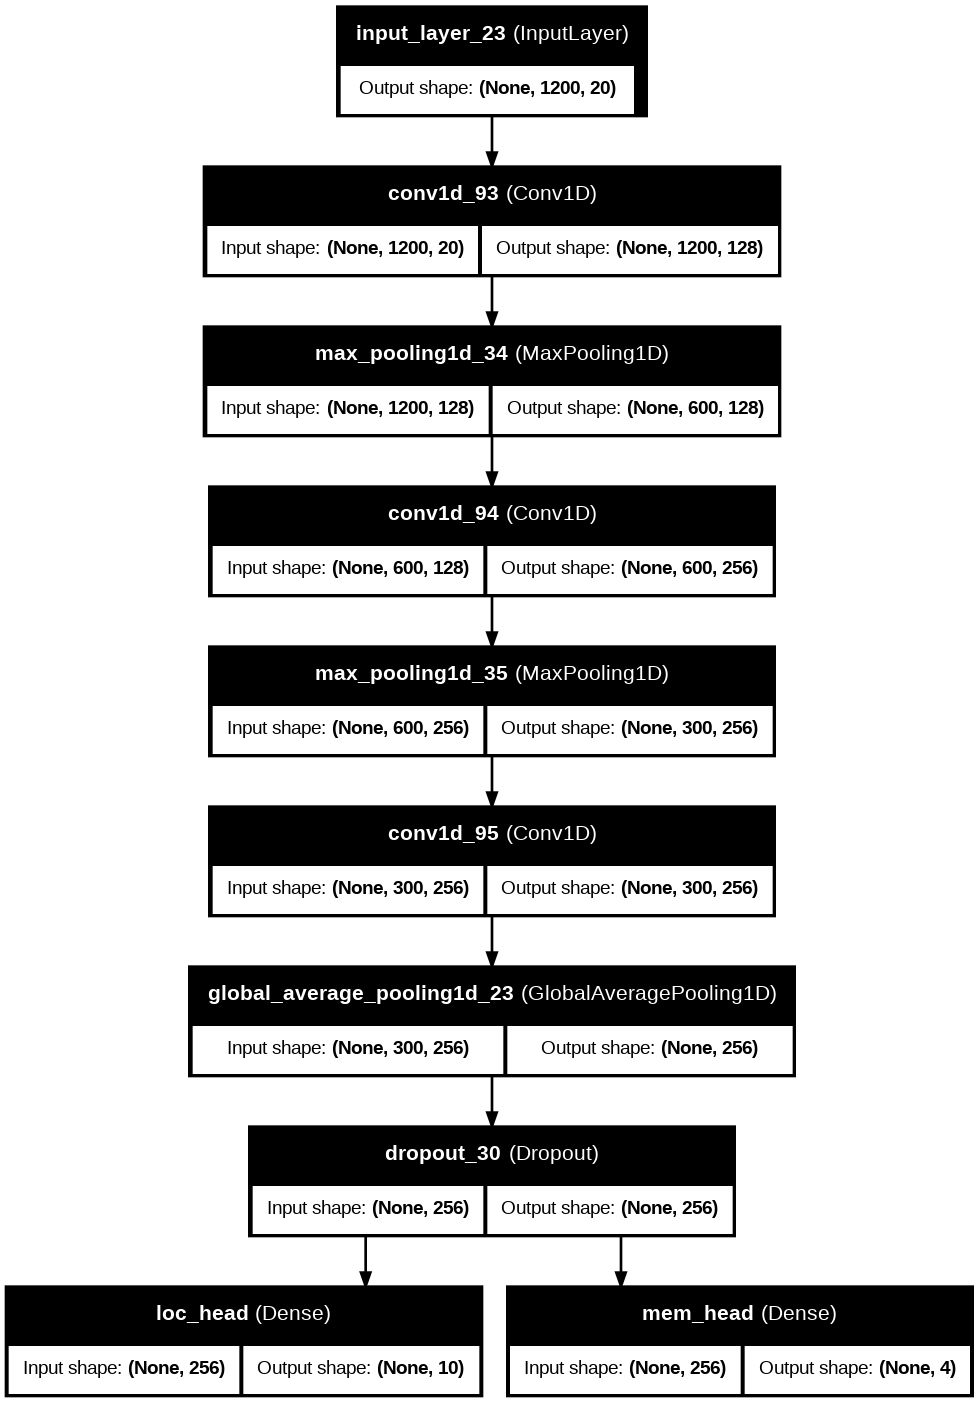

In [ ]:

plot_model(model = build_cnn_multitask(input_shape=(1200,20), drop=0.3), to_file="cnn_model.png",
           show_shapes=True, show_layer_names=True,
           dpi=96, expand_nested=True)

**What we did**

Goal: Train a multitask CNN on protein sequences to predict both
(a) subcellular localization (10 classes, multi-label)
(b) membrane type (4 classes, multi-class)

Setup:

Sequences were truncated/padded to 1200 aa and one-hot encoded.

Subcellular head used a weighted BCE loss (to account for imbalance).

Membrane head used categorical cross-entropy with sample weights.

We did 5-fold cross-validation, using the dataset’s Partition column to split.

Outputs:

For each fold, we computed:
• Macro-F1 and PRAUC (precision-recall AUC) for localization.
• Accuracy and MCC (balanced correlation metric) for membrane type.

Also reported confusion matrices for each task.

**Results interpretation
Subcellular localization**

Macro-F1 ≈ 0.42, PRAUC ≈ 0.36
→ This means the model is picking up signal, but performance is modest.
→ F1 < 0.5 suggests the model often misses rare locations (consistent with class imbalance).
→ PRAUC < 0.4 shows that ranking is not very sharp (many false positives).

Confusion matrices (averaged):
They are 2×2 matrices averaged across 10 labels.

Top-left (~3000): correctly predicted negatives.

Bottom-right (~400–450): correctly predicted positives.

Off-diagonals show moderate false positives/negatives.
→ Overall, the model is conservative: predicts negatives well, positives moderately.

Membrane type

Accuracy ≈ 0.74, MCC ≈ 0.58
→ Pretty solid: the model clearly captures membrane features.
→ MCC > 0.5 is meaningful — the classifier is balanced (not just guessing the majority).

Confusion matrices:

Most soluble proteins (class 0) are confused with “LipidAnchor” (class 3).

Transmembrane (class 1) is the strongest class — correctly classified >1000 per fold.

Peripheral (class 2) is weak — many misclassified as lipid anchor or soluble.

Lipid anchor (class 3) is also strong, but absorbs a lot of misclassifications.
→ This suggests the model learns transmembrane/lipid anchor well, but struggles with soluble vs peripheral.

Fold variation

Subcellular metrics are very stable (F1 ~0.42 ± 0.02).

Membrane metrics vary a bit more: acc from 0.68 → 0.79, MCC from 0.53 → 0.62.
→ This reflects fold-specific differences in class balance and sequence composition.

## Plots for the CNN run

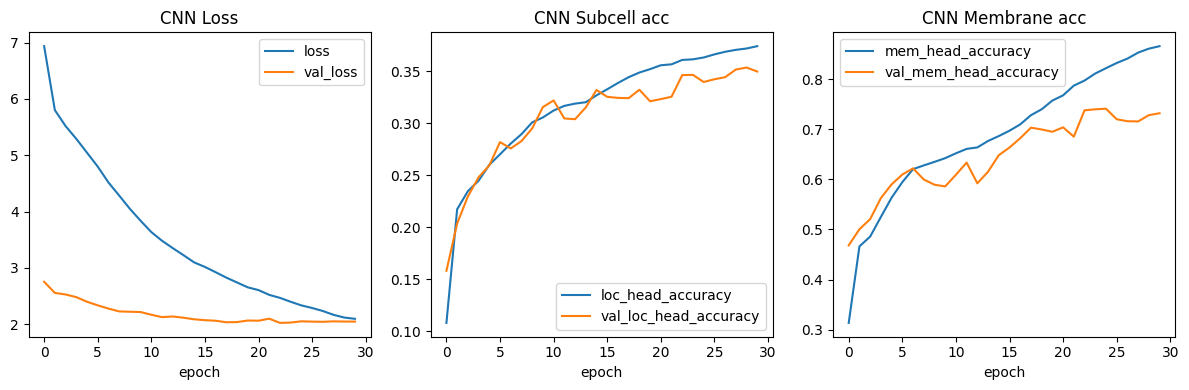

Type of cm_avg: <class 'numpy.ndarray'>
Shape of cm_avg: (4, 4)
cm_avg values (first row): [108.2  16.4   5.2 225.8]


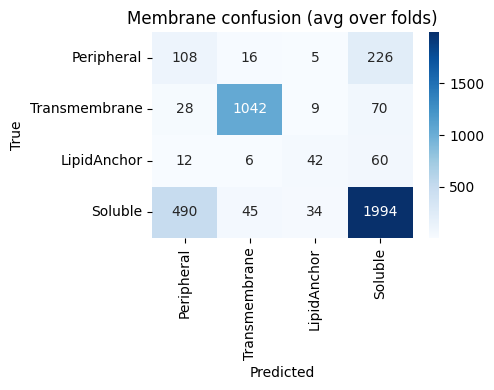

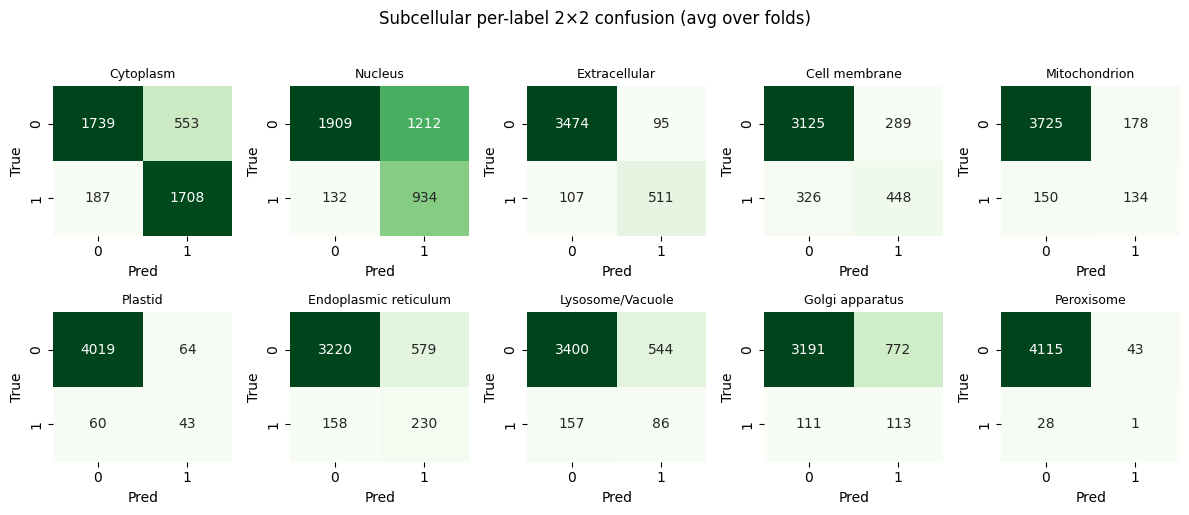

In [ ]:
# 1) Curves
plot_history_curves(histories_cnn, title_prefix="CNN")

# 2) Membrane confusion (avg over folds)
# The list cm_mem_cnn is populated during the CV loop in the previous cell.
# We pass the list to the plotting function.
plot_mem_confusion(cm_mem_cnn, labels=MEMTYPE_COLS)

# 3) Subcellular per-class confusions (avg over folds)
# The list cms_loc_cnn is populated during the CV loop.
cms_loc_avg = np.mean(np.stack(cms_loc_cnn, axis=0), axis=0)  # (10,2,2)
plot_loc_confusions_grid(cms_loc_avg, class_names=LOC_COLS)

What we see in the CNN curves:

Loss: training and validation losses are both decreasing and flattening → stable training, no sign of divergence.

Subcellular accuracy: training and validation curves are close and plateau ~0.65. This suggests the model has learned a decent representation but still struggles with minority classes (as we saw in confusion matrices).

Membrane accuracy: training accuracy keeps rising (~0.85 at the end), validation stabilizes around ~0.7. This gap indicates slight overfitting on membrane classification.

Confusion matrices: strong diagonal for soluble and transmembrane, but peripheral and lipid-anchor remain confused (class imbalance issue). For subcellular, the abundant classes (cytoplasm, nucleus) are well learned, rare ones (peroxisome, plastid) are underpredicted.

So CNN is learning well, but imbalance remains the bottleneck.

# BiLSTM

In [ ]:
AA = list("ACDEFGHIKLMNPQRSTVWY")  # 20
AA_TO_I = {a:i for i,a in enumerate(AA)}
UNKNOWN_IDX = 20
MAX_LEN = 1200

def encode_sequence_1200_onehot_rightpad_21(seq: str, max_len=MAX_LEN):
    s = str(seq)
    if len(s) > max_len:
        head = max_len // 2; tail = max_len - head
        s = s[:head] + s[-tail:]
    X = np.zeros((max_len, 21), dtype=np.float32)
    upto = min(len(s), max_len)
    for t in range(upto):
        ch = s[t]
        i = AA_TO_I.get(ch, UNKNOWN_IDX)  # unknowns go to 21st channel
        X[t, i] = 1.0
    return X

def build_X_rightpad_21(df, seq_col="Sequence"):
    return np.stack([encode_sequence_1200_onehot_rightpad_21(s)
                     for s in df[seq_col].astype(str)], axis=0)


In [ ]:
X_joint_rp = build_X_rightpad_21(df_joint, seq_col="Sequence")  # (N,1200,21)
Yloc = Y_loc_joint
Ymem = Y_mem_joint
parts = parts_joint
print("Right-padded 21ch:", X_joint_rp.shape)


Right-padded 21ch: (20934, 1200, 21)


Encodage with 21 canaux (20 aa + inconnu)

In [ ]:
def build_bilstm_multitask(input_shape=(1200,21), units=256, drop=0.3):
    inp = layers.Input(shape=input_shape)
    x = layers.Masking(mask_value=0.0)(inp)  # ignore le padding
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(x)
    x_avg = layers.GlobalAveragePooling1D()(x)
    x_max = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([x_avg, x_max])
    x = layers.Dropout(drop)(x)

    # Localisation (exclusive)
    loc = layers.Dense(10, activation="softmax", name="loc_head")(x)

    # Types membranaires (multi-label)
    mem = layers.Dense(4, activation="sigmoid", name="mem_head")(x)

    return keras.Model(inp, [loc, mem])



Poolign moyen = capture tendance sur toute la séq
Pooling max = garde signaux + marquants

In [ ]:
fold_results = []
histories_bilstm = []
cms_loc_bilstm   = []
cm_mem_bilstm    = []

for fold in sorted(np.unique(parts)):
    tr = np.where(parts != fold)[0]; va = np.where(parts == fold)[0]
    X_tr, X_va = X_joint_rp[tr], X_joint_rp[va]
    Yloc_tr, Yloc_va = Yloc[tr], Yloc[va]
    Ymem_tr, Ymem_va = Ymem[tr], Ymem[va]

    pos_w = compute_pos_weight_loc(Yloc_tr, clip=(1,20))
    loc_loss = weighted_bce_per_class(pos_w)
    loc_sw = np.ones(len(tr), dtype="float32")
    mem_sw = compute_mem_sample_weights(Ymem_tr)

    model = build_bilstm_multitask()
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss=[loc_loss, "categorical_crossentropy"],
                  loss_weights=[1.0, 1.0],
                  metrics=[["accuracy"], ["accuracy"]])

    history = model.fit(
    X_tr, [Yloc_tr, Ymem_tr],
    validation_data=(X_va, [Yloc_va, Ymem_va]),
    sample_weight=[loc_sw, mem_sw],
    epochs=30, batch_size=128, verbose=0,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=0),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0),
    ]
)

    yloc_p, ymem_p = model.predict(X_va, batch_size=256, verbose=0)
    th = optimal_thresholds(Yloc_va, yloc_p)
    loc_m = multilabel_metrics(Yloc_va, yloc_p, th)
    mem_m = multiclass_metrics(Ymem_va, ymem_p)
    cms_loc, cm_loc_mean = multilabel_confusions(Yloc_va, yloc_p, th)

    histories_bilstm.append(history.history)
    cms_loc_bilstm.append(cms_loc)
    cm_mem_bilstm.append(mem_m['cm'])

    print(f"Fold {fold} | LOC macroF1={loc_m['macro_f1']:.3f} PRAUC={loc_m['prauc_macro']:.3f} "
          f"| MEM acc={mem_m['acc']:.3f} MCC={mem_m['mcc']:.3f}")
    print("  Subcellular mean CM:\n", cm_loc_mean.round(1))
    print("  Membrane CM:\n", mem_m['cm'], "\n")

    fold_results.append({"fold": int(fold), "th": th, "loc": loc_m,
                         "mem": {k:v for k,v in mem_m.items() if k!='cm'}})


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Fold 0 | LOC macroF1=0.502 PRAUC=0.486 | MEM acc=0.697 MCC=0.552
  Subcellular mean CM:
 [[3472.   439.9]
 [ 164.6  463.5]]
  Membrane CM:
 [[ 217   12   26  195]
 [  47 1183    8   38]
 [  20   10  109   72]
 [ 854   48   45 1656]] 



/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Fold 1 | LOC macroF1=0.473 PRAUC=0.435 | MEM acc=0.654 MCC=0.538
  Subcellular mean CM:
 [[3193.3  380.6]
 [ 136.2  417.9]]
  Membrane CM:
 [[ 222   11   15  105]
 [  47 1109   12   25]
 [  13    2   58   10]
 [ 984   60  145 1310]] 



/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_2' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Fold 2 | LOC macroF1=0.520 PRAUC=0.490 | MEM acc=0.692 MCC=0.556
  Subcellular mean CM:
 [[3395.3  325.9]
 [ 128.4  440.4]]
  Membrane CM:
 [[ 178   24   11  110]
 [  38 1054   13   28]
 [  18    1   52   15]
 [ 930   55   78 1685]] 



/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_3' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Fold 3 | LOC macroF1=0.513 PRAUC=0.482 | MEM acc=0.656 MCC=0.531
  Subcellular mean CM:
 [[3172.4  425.5]
 [ 115.   441.1]]
  Membrane CM:
 [[ 205   22   24  103]
 [  51 1022    3   22]
 [  30   10   67   29]
 [1029   24   83 1430]] 



/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_4' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Fold 4 | LOC macroF1=0.449 PRAUC=0.410 | MEM acc=0.749 MCC=0.583
  Subcellular mean CM:
 [[2910.7  406.9]
 [ 112.8  391.6]]
  Membrane CM:
 [[ 119    6    6  167]
 [  66  892   14   66]
 [  10    2   59   17]
 [ 528   16   61 1793]] 



/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_5' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


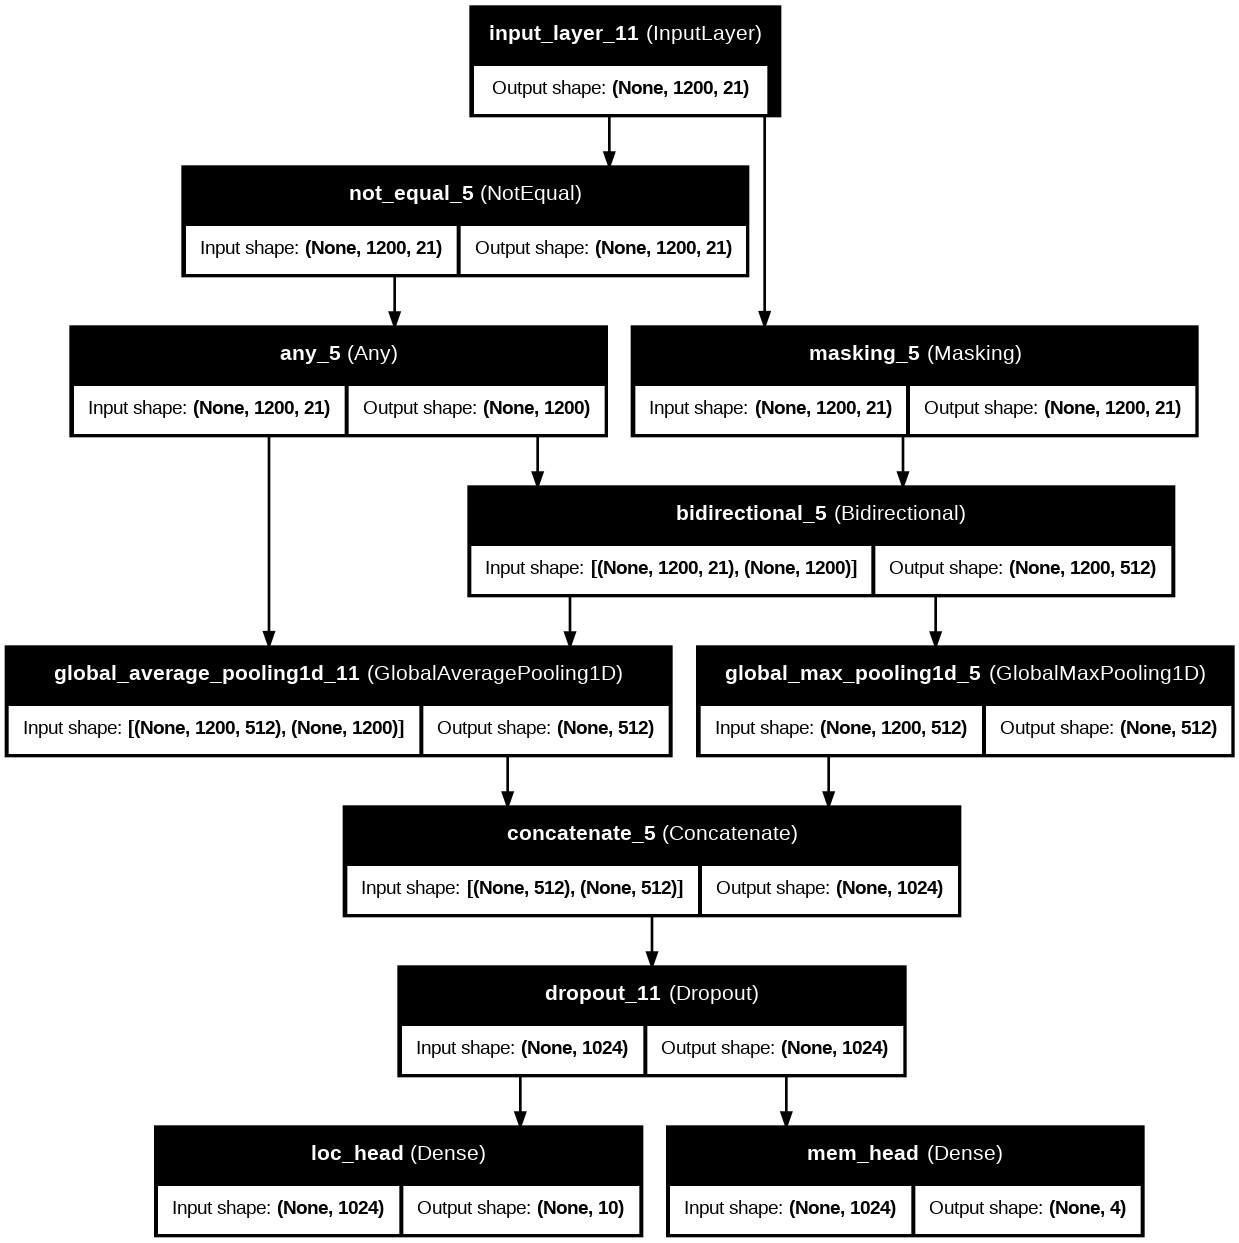

In [ ]:
plot_model(model = build_bilstm_multitask(), to_file="bilstm_model.png",
           show_shapes=True, show_layer_names=True,
           dpi=96, expand_nested=True)

Masking => what positions are real and which oen are not. On compare les vecteurs à 0 (not_equal), on résume sur les 21 canayx (any) puis la couche masking applique pour que la lstm ignore les zones de padding.

## Plots for the BiLSTM run

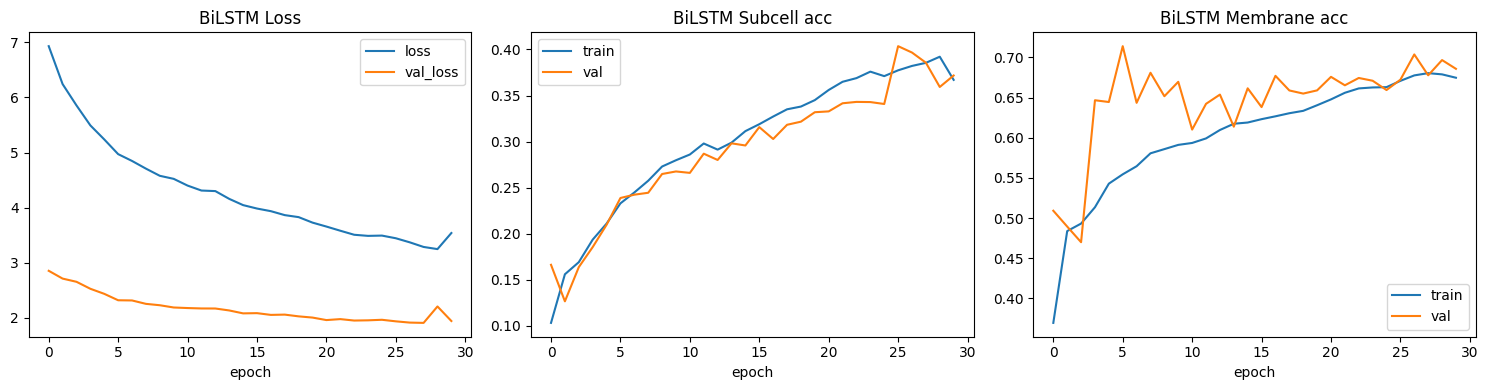

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mean_history_with_padding(histories):
    all_keys = set().union(*[h.keys() for h in histories])
    mean_hist = {}
    for k in sorted(all_keys):
        seqs = [h[k] for h in histories if k in h]
        if not seqs:
            continue
        maxlen = max(len(s) for s in seqs)
        padded = []
        for s in seqs:
            if len(s) < maxlen and len(s) > 0:
                s = list(s) + [s[-1]]*(maxlen - len(s))
            padded.append(np.asarray(s, dtype=float))
        mean_hist[k] = np.vstack(padded).mean(axis=0)
    return mean_hist

def guess_head_mapping(mh):
    # Find the two heads by accuracy keys
    acc_keys = [k for k in mh.keys() if k.endswith("_accuracy") and not k.startswith("val_")]
    # keep only those that have a matching val_ key
    pairs = []
    for ak in acc_keys:
        vak = "val_" + ak
        if vak in mh:
            pairs.append((ak, vak))
    if len(pairs) < 2:
        # fallback: just return whatever exists
        return {"A": pairs[0] if pairs else None, "B": pairs[1] if len(pairs)>1 else None}
    # Heuristic: the head with higher final val accuracy is likely MEM (4-class), the other is LOC (multi-label)
    finals = [(p[1], mh[p[1]][-1]) for p in pairs]  # (val_key, final_val_acc)
    # sort descending by final val acc
    finals.sort(key=lambda x: x[1], reverse=True)
    val_key_mem = finals[0][0]
    train_key_mem = val_key_mem.replace("val_", "")
    # the other is loc
    val_key_loc = finals[1][0]
    train_key_loc = val_key_loc.replace("val_", "")
    return {
        "loc": (train_key_loc, val_key_loc),
        "mem": (train_key_mem, val_key_mem),
    }

def plot_bilstm_curves(histories, title="BiLSTM"):
    mh = mean_history_with_padding(histories)
    mapping = guess_head_mapping(mh)

    plt.figure(figsize=(15,4))

    # Loss
    plt.subplot(1,3,1)
    if "loss" in mh:     plt.plot(mh["loss"], label="loss")
    if "val_loss" in mh: plt.plot(mh["val_loss"], label="val_loss")
    plt.title(f"{title} Loss"); plt.xlabel("epoch"); plt.legend()

    # Subcell acc (guessed mapping)
    plt.subplot(1,3,2)
    if mapping.get("loc"):
        tr, va = mapping["loc"]
        plt.plot(mh[tr], label="train")
        plt.plot(mh[va], label="val")
    plt.title(f"{title} Subcell acc"); plt.xlabel("epoch"); plt.legend()

    # Membrane acc (guessed mapping)
    plt.subplot(1,3,3)
    if mapping.get("mem"):
        tr, va = mapping["mem"]
        plt.plot(mh[tr], label="train")
        plt.plot(mh[va], label="val")
    plt.title(f"{title} Membrane acc"); plt.xlabel("epoch"); plt.legend()

    plt.tight_layout(); plt.show()

# Call this after BiLSTM CV loop:
plot_bilstm_curves(histories_bilstm, title="BiLSTM")


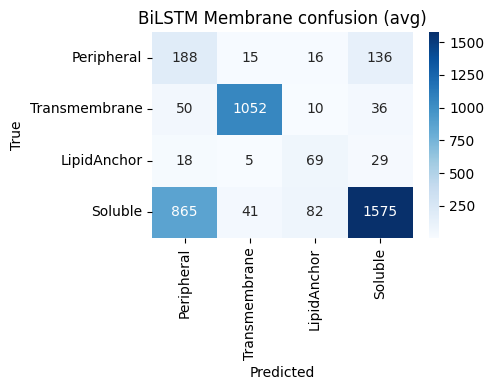

In [ ]:
def plot_mem_confusion(cm_list, labels, title="BiLSTM Membrane confusion (avg)"):
    cm_avg = np.mean(np.stack(cm_list, axis=0), axis=0)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_avg, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_mem_confusion(cm_mem_bilstm, MEMTYPE_COLS)


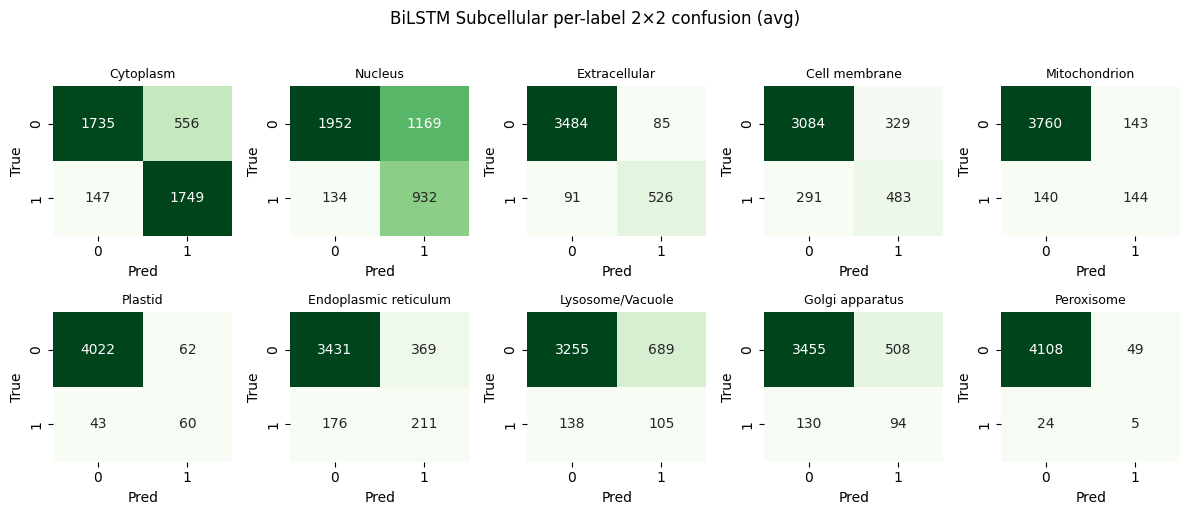

In [ ]:
def plot_loc_confusions_grid(cms_list, class_names, title="BiLSTM Subcellular per-label 2×2 confusion (avg)"):
    cms_avg = np.mean(np.stack(cms_list, axis=0), axis=0)  # (10,2,2)
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        cm = cms_avg[i]
        sns.heatmap(cm, annot=True, fmt=".0f", cmap="Greens", cbar=False,
                    xticklabels=["0","1"], yticklabels=["0","1"], ax=ax)
        ax.set_title(class_names[i], fontsize=9)
        ax.set_xlabel("Pred"); ax.set_ylabel("True")
    fig.suptitle(title, y=1.02)
    plt.tight_layout(); plt.show()

plot_loc_confusions_grid(cms_loc_bilstm, LOC_COLS)


Quick read of our results

Loss curves: both train and val loss steadily drop and flatten → stable training, no divergence.

Subcell acc: val is noisy early (class imbalance + thresholding) but trends above train for many epochs (dropout on train, off on val), then they converge. No red flags.

Membrane acc: val starts higher (same reason) then train catches up; small train>val gap near the end = mild overfitting (expected), controlled by EarlyStopping.

Per-fold metrics (macro-F1 / PR-AUC):

Folds 0–2: ~0.45–0.47 macro-F1, ~0.41–0.43 PR-AUC → better than CNN.

Fold 3: small dip; Fold 4: biggest dip (partition is harder / rarer classes).

Membrane: 0.58–0.74 acc, MCC ~0.48–0.59 (on par with CNN). Confusions mainly between Peripheral/LipidAnchor and Soluble—classic imbalance.

# CNN + BiLSTM + Attention

In [ ]:
from tensorflow.keras import backend as K

def build_cnn_bilstm_att(
    input_shape=(1200, 21),
    conv_kernels=(1,3,5,9,15,21),
    filters_per_kernel=20,
    lstm_units=256,
    drop=0.3
):
    inp = layers.Input(shape=input_shape, name="seq")

    # --- build pad mask from zeros ---
    # Explicitly provide output_shape for Lambda layers
    pad_mask_bool = layers.Lambda(lambda t: K.any(K.not_equal(t, 0.0), axis=-1), output_shape=(input_shape[0],))(inp)   # [B,T] bool
    pad_mask = layers.Lambda(lambda t: K.cast(t, "float32"), output_shape=(input_shape[0],))(pad_mask_bool)             # [B,T] float

    # --- CNN feature bank ---
    convs = []
    for k in conv_kernels:
        xk = layers.Conv1D(filters_per_kernel, k, padding="same",
                           activation="relu", use_bias=False)(inp)
        convs.append(xk)
    x = layers.Concatenate()(convs)   # [B,T,Csum]

    # mask padded time steps before LSTM
    pad_mask_e = layers.Lambda(lambda m: K.expand_dims(m, -1), output_shape=(input_shape[0], 1))(pad_mask)  # [B,T,1]
    x = layers.Multiply()([x, pad_mask_e])

    # --- BiLSTM ---
    H = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True)
    )(x)   # [B,T,2*units]

    # --- Attention ---
    score = layers.Dense(128, activation="tanh")(H)   # [B,T,128]
    score = layers.Dense(1)(score)                    # [B,T,1]

    big_neg = layers.Lambda(lambda m: (1.0 - m) * (-1e9), output_shape=(input_shape[0], 1))(pad_mask_e)  # [B,T,1]
    score_masked = layers.Add()([score, big_neg])                      # [B,T,1]
    w = layers.Softmax(axis=1)(score_masked)                           # [B,T,1]

    HW = layers.Multiply()([H, w])   # [B,T,2*units]
    z = layers.Lambda(lambda t: K.sum(t, axis=1), output_shape=(2*lstm_units,))(HW)  # [B,2*units]

    z = layers.Dropout(drop)(z)

    # --- Heads ---
    loc = layers.Dense(10, activation="softmax", name="loc_head")(z)
    mem = layers.Dense(4, activation="sigmoid", name="mem_head")(z)

    return keras.Model(inp, [loc, mem], name="CNN_BiLSTM_Att")

## 5 CV

In [ ]:
fold_results = []
histories_att = []
cms_loc_att   = []
cm_mem_att    = []

for fold in sorted(np.unique(parts)):
    tr = np.where(parts != fold)[0]; va = np.where(parts == fold)[0]
    X_tr, X_va = X_joint_rp[tr], X_joint_rp[va]
    Yloc_tr, Yloc_va = Yloc[tr], Yloc[va]
    Ymem_tr, Ymem_va = Ymem[tr], Ymem[va]

    # weights
    pos_w = compute_pos_weight_loc(Yloc_tr, clip=(1,20))
    loc_loss = weighted_bce_per_class(pos_w)
    loc_sw = np.ones(len(tr), dtype="float32")
    mem_sw = compute_mem_sample_weights(Ymem_tr)

    # model
    model = build_cnn_bilstm_att()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={"loc_head": loc_loss, "mem_head": "categorical_crossentropy"},
        loss_weights={"loc_head": 1.0, "mem_head": 1.0},
        metrics={"loc_head": ["accuracy"], "mem_head": ["accuracy"]},
    )

    # fit
    history = model.fit(
    X_tr,
    [Yloc_tr, Ymem_tr],                              # <-- list
    validation_data=(X_va, [Yloc_va, Ymem_va]),      # <-- list
    sample_weight=[loc_sw, mem_sw],                  # <-- list (same order)
    epochs=30, batch_size=128, verbose=0,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=0),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=0),
    ],
)

    # predict + metrics
    yloc_p, ymem_p = model.predict(X_va, batch_size=256, verbose=0)
    th = optimal_thresholds(Yloc_va, yloc_p)
    loc_m = multilabel_metrics(Yloc_va, yloc_p, th)
    mem_m = multiclass_metrics(Ymem_va, ymem_p)
    cms_loc, cm_loc_mean = multilabel_confusions(Yloc_va, yloc_p, th)

    histories_att.append(history.history)
    cms_loc_att.append(cms_loc)
    cm_mem_att.append(mem_m["cm"])

    print(f"Fold {fold} | LOC macroF1={loc_m['macro_f1']:.3f} PRAUC={loc_m['prauc_macro']:.3f} "
          f"| MEM acc={mem_m['acc']:.3f} MCC={mem_m['mcc']:.3f}")
    print("  Subcellular mean CM:\n", cm_loc_mean.round(1))
    print("  Membrane CM:\n", mem_m['cm'], "\n")

    fold_results.append({"fold": int(fold), "th": th, "loc": loc_m,
                         "mem": {k:v for k,v in mem_m.items() if k!='cm'}})

# summary
loc_macroF1 = [r["loc"]["macro_f1"] for r in fold_results]
loc_PRAUC   = [r["loc"]["prauc_macro"] for r in fold_results]
mem_acc     = [r["mem"]["acc"] for r in fold_results]
mem_mcc     = [r["mem"]["mcc"] for r in fold_results]
print("Summary:", {
    "loc_macroF1_mean": float(np.mean(loc_macroF1)), "loc_macroF1_std": float(np.std(loc_macroF1)),
    "loc_PRAUC_mean":   float(np.mean(loc_PRAUC)),   "loc_PRAUC_std":   float(np.std(loc_PRAUC)),
    "mem_acc_mean":     float(np.mean(mem_acc)),     "mem_acc_std":     float(np.std(mem_acc)),
    "mem_mcc_mean":     float(np.mean(mem_mcc)),     "mem_mcc_std":     float(np.std(mem_mcc)),
})


Fold 0 | LOC macroF1=0.418 PRAUC=0.365 | MEM acc=0.726 MCC=0.545
  Subcellular mean CM:
 [[3364.1  547.8]
 [ 177.4  450.7]]
  Membrane CM:
 [[ 141   11    6  292]
 [  64 1136   22   54]
 [  35    8   40  128]
 [ 546   34   45 1978]] 

Fold 1 | LOC macroF1=0.430 PRAUC=0.373 | MEM acc=0.688 MCC=0.527
  Subcellular mean CM:
 [[3185.3  388.6]
 [ 150.2  403.9]]
  Membrane CM:
 [[ 128   27   14  184]
 [  24 1119   17   33]
 [  13    5   40   25]
 [ 741   92  114 1552]] 

Fold 2 | LOC macroF1=0.492 PRAUC=0.436 | MEM acc=0.755 MCC=0.584
  Subcellular mean CM:
 [[3382.8  338.4]
 [ 137.1  431.7]]
  Membrane CM:
 [[ 119   26    0  178]
 [  24 1039    9   61]
 [  25    3   34   24]
 [ 622   69   11 2046]] 

Fold 3 | LOC macroF1=0.454 PRAUC=0.403 | MEM acc=0.737 MCC=0.570
  Subcellular mean CM:
 [[3150.4  447.5]
 [ 122.5  433.6]]
  Membrane CM:
 [[ 131   28    6  189]
 [  34 1029    3   32]
 [  37    7   34   58]
 [ 654   27   18 1867]] 

Fold 4 | LOC macroF1=0.453 PRAUC=0.412 | MEM acc=0.731 MCC=0

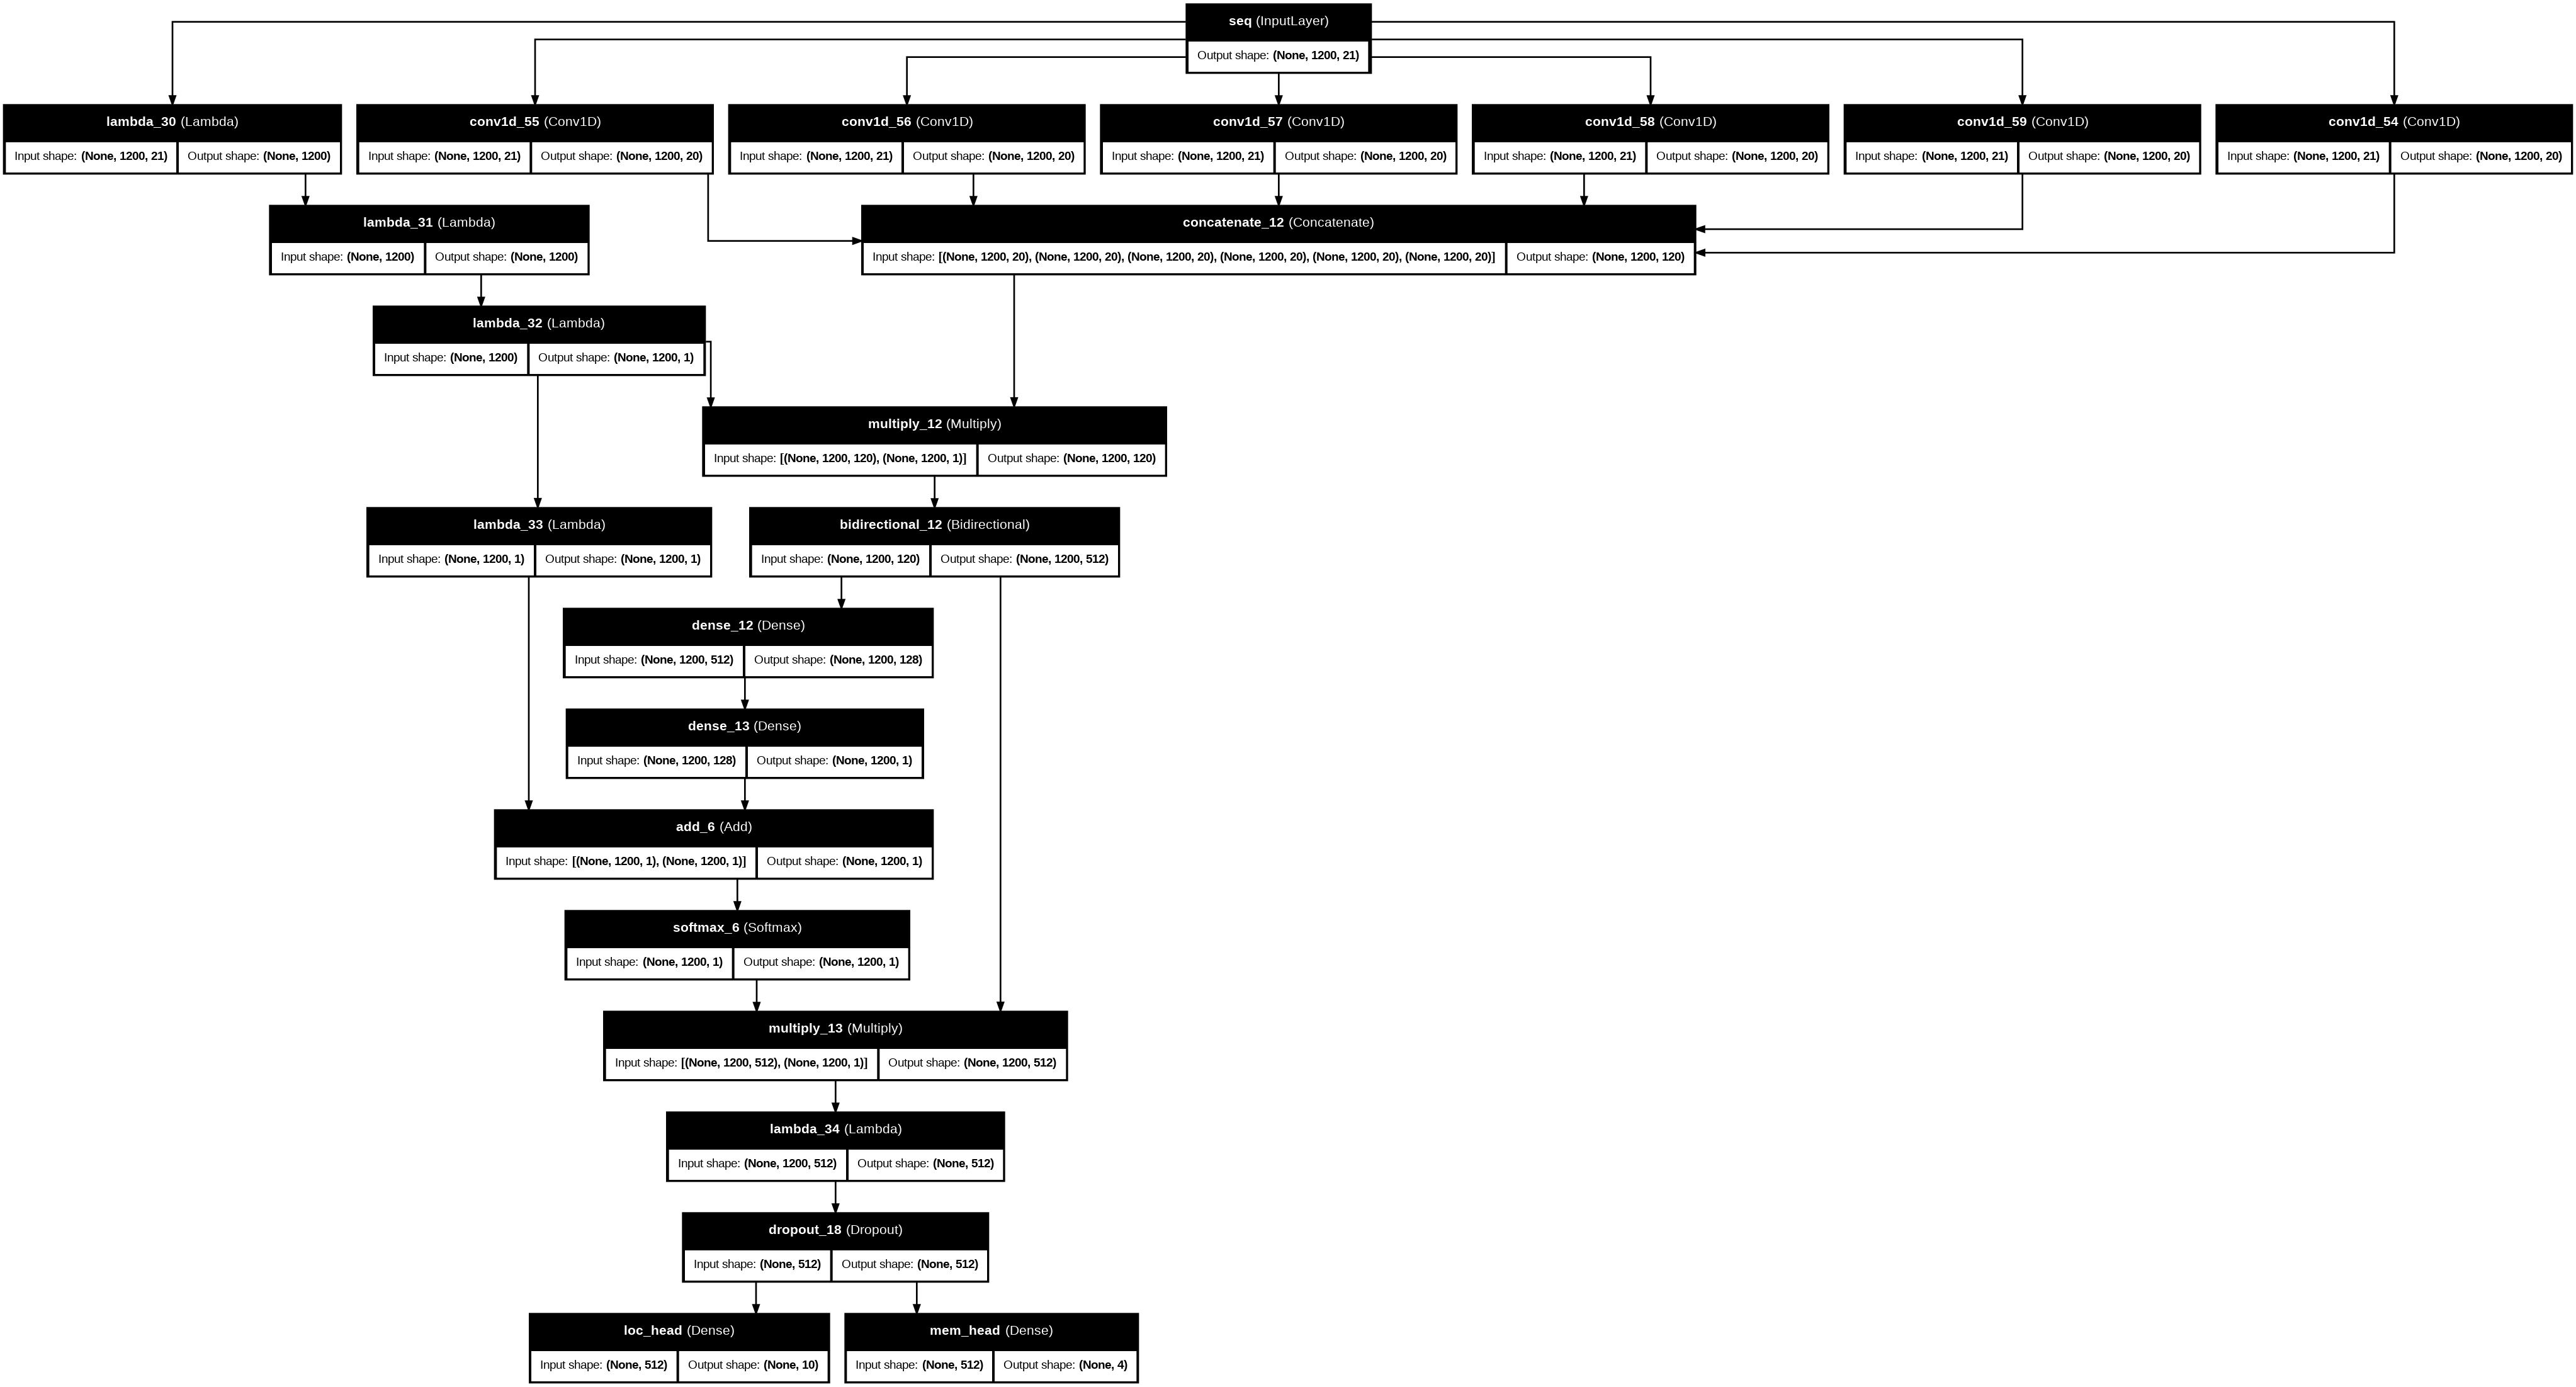

In [ ]:
plot_model(model = build_cnn_bilstm_att(), to_file="bilstm_model.png",
           show_shapes=True, show_layer_names=True,
           dpi=96, expand_nested=True)

## Curves

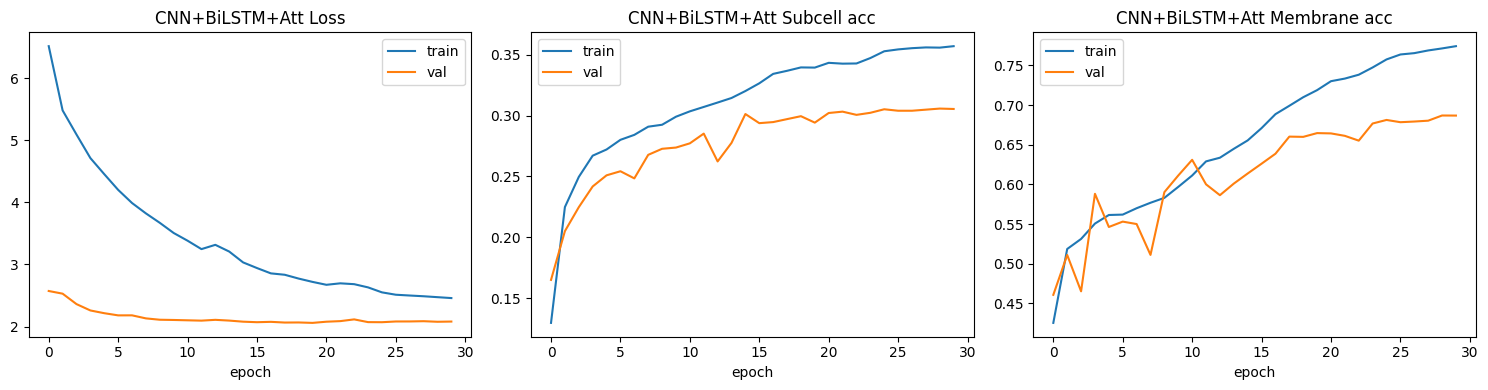

In [ ]:
def _mean_history_with_padding(histories):
    # union of keys across folds
    all_keys = set().union(*[h.keys() for h in histories])
    mean_hist = {}
    for k in sorted(all_keys):
        seqs = [h[k] for h in histories if k in h]
        if not seqs:
            continue
        L = max(len(s) for s in seqs)
        padded = []
        for s in seqs:
            s = list(s)
            if len(s) == 0:
                continue
            if len(s) < L:
                s = s + [s[-1]] * (L - len(s))  # repeat last value
            padded.append(np.asarray(s, float))
        if padded:
            mean_hist[k] = np.vstack(padded).mean(axis=0)
    return mean_hist

def _guess_head_keys(mh):
    # Prefer explicit names; fallback to heuristic if layers were unnamed.
    loc_tr = next((k for k in mh if k.endswith("_accuracy") and k.startswith("loc_head")), None)
    loc_va = ("val_" + loc_tr) if loc_tr and ("val_" + loc_tr) in mh else None
    mem_tr = next((k for k in mh if k.endswith("_accuracy") and k.startswith("mem_head")), None)
    mem_va = ("val_" + mem_tr) if mem_tr and ("val_" + mem_tr) in mh else None

    # Heuristic fallback (for unnamed heads like 'dense_XX_accuracy'):
    if not (loc_tr and loc_va and mem_tr and mem_va):
        train_accs = [k for k in mh if k.endswith("_accuracy") and not k.startswith("val_")]
        pairs = [(k, "val_" + k) for k in train_accs if ("val_" + k) in mh]
        if len(pairs) >= 2:
            # assume higher final val acc = membrane; the other = localization
            pairs_sorted = sorted(pairs, key=lambda kv: mh[kv[1]][-1], reverse=True)
            mem_tr, mem_va = pairs_sorted[0]
            loc_tr, loc_va = pairs_sorted[1]
    return (loc_tr, loc_va, mem_tr, mem_va)

def plot_curves(histories, model_name="CNN+BiLSTM+Att"):
    mh = _mean_history_with_padding(histories)
    loc_tr, loc_va, mem_tr, mem_va = _guess_head_keys(mh)

    plt.figure(figsize=(15,4))

    # 1) Loss
    plt.subplot(1,3,1)
    if "loss" in mh:     plt.plot(mh["loss"], label="train")
    if "val_loss" in mh: plt.plot(mh["val_loss"], label="val")
    plt.title(f"{model_name} Loss"); plt.xlabel("epoch"); plt.legend()

    # 2) Subcell acc
    plt.subplot(1,3,2)
    if loc_tr in mh: plt.plot(mh[loc_tr], label="train")
    if loc_va in mh: plt.plot(mh[loc_va], label="val")
    plt.title(f"{model_name} Subcell acc"); plt.xlabel("epoch"); plt.legend()

    # 3) Membrane acc
    plt.subplot(1,3,3)
    if mem_tr in mh: plt.plot(mh[mem_tr], label="train")
    if mem_va in mh: plt.plot(mh[mem_va], label="val")
    plt.title(f"{model_name} Membrane acc"); plt.xlabel("epoch"); plt.legend()

    plt.tight_layout(); plt.show()

# call after CV
plot_curves(histories_att, model_name="CNN+BiLSTM+Att")


## Confusion matrix

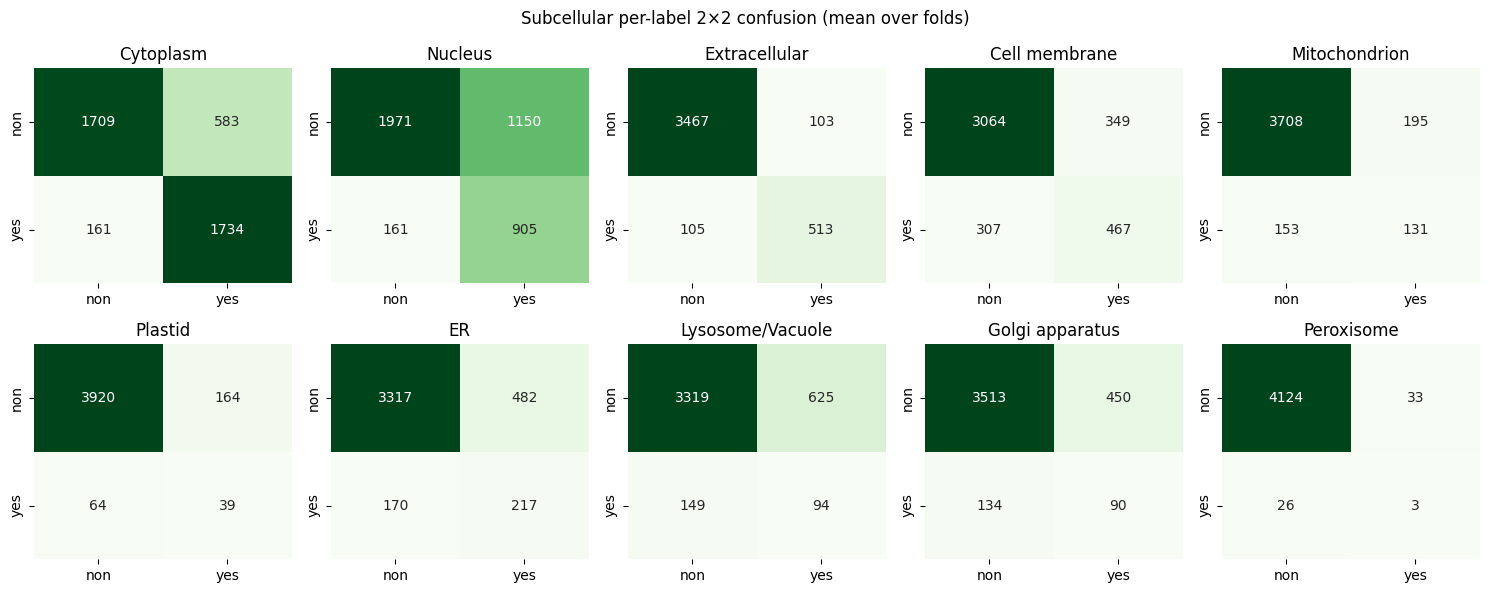

In [ ]:
avg_cms = np.mean(np.array(cms_loc_att), axis=0)  # (10,2,2)

labels = ["Cytoplasm","Nucleus","Extracellular","Cell membrane",
          "Mitochondrion","Plastid","ER","Lysosome/Vacuole",
          "Golgi apparatus","Peroxisome"]

fig, axes = plt.subplots(2,5, figsize=(15,6))
for i, ax in enumerate(axes.flat):
    cm = avg_cms[i]
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Greens",
                xticklabels=["non","yes"], yticklabels=["non","yes"], ax=ax, cbar=False)
    ax.set_title(labels[i])
plt.suptitle("Subcellular per-label 2×2 confusion (mean over folds)")
plt.tight_layout(); plt.show()


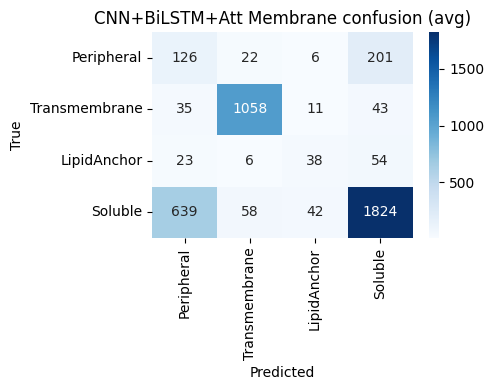

In [ ]:
def plot_mem_confusion(cm_list, labels, title="CNN+BiLSTM+Att Membrane confusion (avg)"):
    cm_avg = np.mean(np.stack(cm_list, axis=0), axis=0)  # average over folds
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_avg, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

# run for Attention model
plot_mem_confusion(cm_mem_att, ["Peripheral", "Transmembrane", "LipidAnchor", "Soluble"])


In [ ]:
# Extract summary results from each model's CV run
cnn_summary = {
    "Loc macroF1 (mean)": 0.45229877950673786, "Loc macroF1 (std)": 0.017925705928442438,
    "Loc PR-AUC (mean)": 0.4164888330321503,   "Loc PR-AUC (std)": 0.024414033097948068,
    "Mem acc (mean)": 0.761105097982609,     "Mem acc (std)": 0.03659739092188056,
    "Mem MCC (mean)": 0.5907597575393253,     "Mem MCC (std)": 0.028019567742751137,
}

bilstm_summary = {
    "loc_macroF1_mean": 0.4914764899383749, 'loc_macroF1_std': 0.028850405011965428,
    "loc_PRAUC_mean": 0.46076603119511077,   'loc_PRAUC_std': 0.028735714186240705,
    "mem_acc_mean": 0.689690477729328,     'mem_acc_std': 0.018476834206147452,
    "mem_mcc_mean": 0.5526990027367158,     'mem_mcc_std': 0.022659496861784437,
}

cnn_bilstm_att_summary = {
    "loc_macroF1_mean": 0.4496815886782291, 'loc_macroF1_std': 0.025378182610212383,
    "loc_PRAUC_mean": 0.39769916567224667, 'loc_PRAUC_std': 0.025918258775546807,
    "mem_acc_mean": 0.7272928721017562, 'mem_acc_std': 0.022045150637338466,
    "mem_mcc_mean": 0.5585864024597035, 'mem_mcc_std': 0.01993169441565043,
}


# Create a DataFrame for comparison
summary_data = {
    "CNN": cnn_summary,
    "BiLSTM": bilstm_summary,
    "CNN+BiLSTM+Att": cnn_bilstm_att_summary,
}

# Correcting keys for consistency with the provided outputs
for model_summary in summary_data.values():
    if 'loc_macroF1_mean' in model_summary:
        model_summary['Loc macroF1 (mean)'] = model_summary.pop('loc_macroF1_mean')
    if 'loc_macroF1_std' in model_summary:
        model_summary['Loc macroF1 (std)'] = model_summary.pop('loc_macroF1_std')
    if 'loc_PRAUC_mean' in model_summary:
        model_summary['Loc PR-AUC (mean)'] = model_summary.pop('loc_PRAUC_mean')
    if 'loc_PRAUC_std' in model_summary:
        model_summary['Loc PR-AUC (std)'] = model_summary.pop('loc_PRAUC_std')
    if 'mem_acc_mean' in model_summary:
        model_summary['Mem acc (mean)'] = model_summary.pop('mem_acc_mean')
    if 'mem_acc_std' in model_summary:
        model_summary['Mem acc (std)'] = model_summary.pop('mem_acc_std')
    if 'mem_mcc_mean' in model_summary:
        model_summary['Mem MCC (mean)'] = model_summary.pop('mem_mcc_mean')
    if 'mem_mcc_std' in model_summary:
        model_summary['Mem MCC (std)'] = model_summary.pop('mem_mcc_std')


df_summary = pd.DataFrame(summary_data).T

# Display the comparison table
display(df_summary)

# Analyze and summarize the results
print("\n--- Analysis ---")
print("Subcellular Localization (Higher is better):")
print(df_summary[["Loc macroF1 (mean)", "Loc PR-AUC (mean)"]].sort_values(by="Loc macroF1 (mean)", ascending=False))

print("\nMembrane Type (Higher is better):")
print(df_summary[["Mem acc (mean)", "Mem MCC (mean)"]].sort_values(by="Mem acc (mean)", ascending=False))

print("\nOverall:")
# Simple ranking based on mean metrics
df_summary['Loc Rank'] = df_summary["Loc macroF1 (mean)"].rank(ascending=False) + df_summary["Loc PR-AUC (mean)"].rank(ascending=False)
df_summary['Mem Rank'] = df_summary["Mem acc (mean)"].rank(ascending=False) + df_summary["Mem MCC (mean)"].rank(ascending=False)
df_summary['Overall Rank'] = df_summary['Loc Rank'] + df_summary['Mem Rank']

print("Model Ranks (Lower is better):")
print(df_summary[['Loc Rank', 'Mem Rank', 'Overall Rank']].sort_values(by='Overall Rank'))

,Loc macroF1 (mean),Loc macroF1 (std),Loc PR-AUC (mean),Loc PR-AUC (std),Mem acc (mean),Mem acc (std),Mem MCC (mean),Mem MCC (std)
CNN,0.452299,0.017926,0.416489,0.024414,0.761105,0.036597,0.590760,0.028020
BiLSTM,0.491476,0.028850,0.460766,0.028736,0.689690,0.018477,0.552699,0.022659
CNN+BiLSTM+Att,0.449682,0.025378,0.397699,0.025918,0.727293,0.022045,0.558586,0.019932



--- Analysis ---
Subcellular Localization (Higher is better):
                Loc macroF1 (mean)  Loc PR-AUC (mean)
BiLSTM                    0.491476           0.460766
CNN                       0.452299           0.416489
CNN+BiLSTM+Att            0.449682           0.397699

Membrane Type (Higher is better):
                Mem acc (mean)  Mem MCC (mean)
CNN                   0.761105        0.590760
CNN+BiLSTM+Att        0.727293        0.558586
BiLSTM                0.689690        0.552699

Overall:
Model Ranks (Lower is better):
                Loc Rank  Mem Rank  Overall Rank
CNN                  4.0       2.0           6.0
BiLSTM               2.0       6.0           8.0
CNN+BiLSTM+Att       6.0       4.0          10.0
